# Step 1: Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots prettier
sns.set(style="whitegrid")


# Step 2: Load Cleaned Dataset

In [2]:
# Load cleaned retail dataset
retail_df = pd.read_csv("cleaned_online_retail.csv", parse_dates=["InvoiceDate"])

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


# Step 3: Define Snapshot Date

In [3]:
# Recency reference date (day after last invoice)
snapshot_date = retail_df["InvoiceDate"].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)


Snapshot Date: 2011-12-10 12:50:00


# Step 4: Build RFM Table

In [4]:
# Aggregate by CustomerID
rfm = retail_df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


# Step 5: Assign RFM Scores (1–5)

In [5]:

# Recency: lower is better → invert labels
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency: higher is better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary: higher is better
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

# Combine R, F, M into single numeric score
rfm["RFM_Score"] = rfm["R_Score"]*100 + rfm["F_Score"]*10 + rfm["M_Score"]

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,19,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


# Step 6: Assign Customer Segments

In [6]:
def segment_customer(row):
    if row["RFM_Score"] >= 444:          
        return "Champions"
    elif row["R_Score"] >= 4:
        return "Loyal Customers"
    elif row["F_Score"] >= 4:
        return "Frequent Buyers"
    elif row["R_Score"] <= 2:
        return "At Risk"
    else:
        return "Others"

# Make RFM_Score integer for proper comparison
rfm["RFM_Score"] = rfm["R_Score"]*100 + rfm["F_Score"]*10 + rfm["M_Score"]

# Apply segmentation
rfm["Segment"] = rfm.apply(segment_customer, axis=1)

# Check distribution
print(rfm["Segment"].value_counts())


Segment
At Risk            1433
Champions          1282
Frequent Buyers     596
Others              537
Loyal Customers     490
Name: count, dtype: int64


# Step 7: Visualize Customer Segments

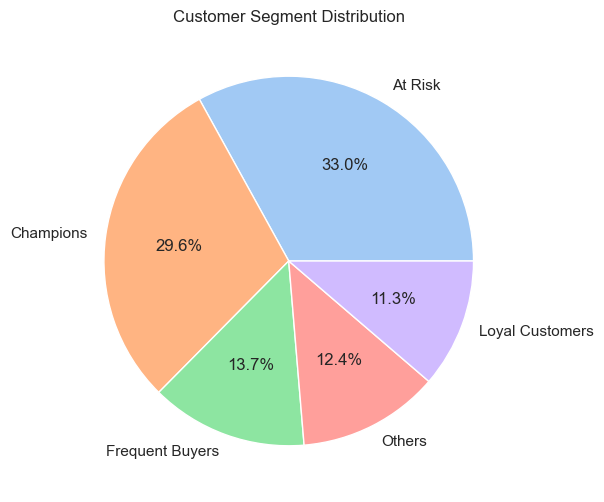

In [7]:
# Pie Chart of Segments
plt.figure(figsize=(6,6))
rfm["Segment"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Customer Segment Distribution")
plt.ylabel("")
plt.show()


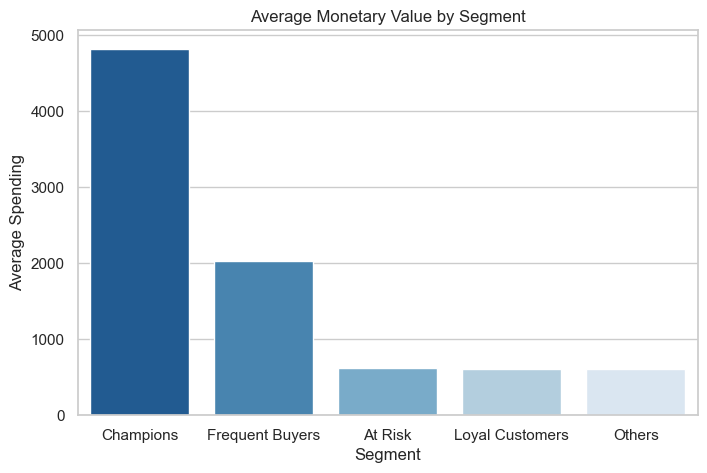

In [8]:
# Average Monetary per Segment
segment_monetary = (
    rfm.groupby("Segment")["Monetary"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))

sns.barplot(
    x=segment_monetary.index,
    y=segment_monetary.values,
    hue=segment_monetary.index,   
    palette="Blues_r",
    legend=False                
)

plt.title("Average Monetary Value by Segment")
plt.ylabel("Average Spending")
plt.xlabel("Segment")

plt.show()


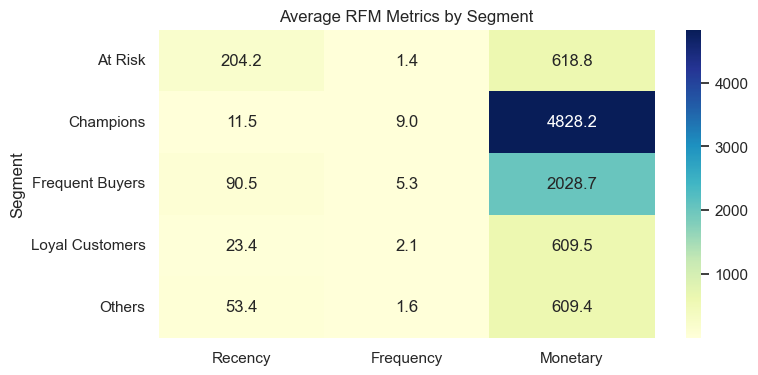

In [9]:
# Recency & Frequency Heatmap
rfm_pivot = rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean()
plt.figure(figsize=(8,4))
sns.heatmap(rfm_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM Metrics by Segment")
plt.show()


In [10]:
# Identify top 10 customers by Monetary:
top_customers = rfm.sort_values("Monetary", ascending=False).head(10)
print(top_customers)


            Recency  Frequency   Monetary  R_Score  F_Score  M_Score  \
CustomerID                                                             
14646.0           2         73  280206.02        5        5        5   
18102.0           1         60  259657.30        5        5        5   
17450.0           8         46  194550.79        5        5        5   
16446.0           1          2  168472.50        5        3        5   
14911.0           1        201  143825.06        5        5        5   
12415.0          24         21  124914.53        4        5        5   
14156.0          10         55  117379.63        5        5        5   
17511.0           3         31   91062.38        5        5        5   
16029.0          39         63   81024.84        3        5        5   
12346.0         326          1   77183.60        1        1        5   

            RFM_Score          Segment  
CustomerID                              
14646.0           555        Champions  
18102.0     